# PNP

In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [39]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [40]:
def treinar_e_roportar(models, X_train, y_train, X_test, y_test):
    for model in models:
        print(model)
        if(model == xgb_model):
            y_train = enc.transform(y_train.array.reshape(-1, 1))
            y_test = enc.transform(y_test.array.reshape(-1, 1))
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        print('Acurácia teste: ', accuracy_score(y_test, preds)*100)
        print(classification_report(y_test, preds, digits=3))
        imprimeMatrizDeConfusão(y_test, preds, model)
        preds = model.predict(X_train)
        print('Acurácia treino: ', accuracy_score(y_train, preds)*100)
        print(classification_report(y_train, preds, digits=3))   

In [74]:
# Função para rodar GLM

def glm_treinar_e_reportar(df_train, df_test, method = 'bfgs'):
    from patsy import dmatrices
    import statsmodels.api as sm

    df_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl', 'Comportamento']]
    df_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl', 'Comportamento']]

    y_train, X_train = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_train, return_type='dataframe')

    y_test, X_test = dmatrices( 'Comportamento ~ X + Y + Z + Season_fall + Season_spring + Season_summer + magn + sma + ent + pit + rol + icl', data=df_test, return_type='dataframe')

    X_train, X_test = reescalar_dados(X_train, X_test)

    glm_model = sm.MNLogit(y_train, X_train) 

    glm_results = glm_model.fit(method=method)

    preds = glm_results.predict(X_test)

    preds[2] = preds.median(axis=1)

    preds = preds.reset_index(drop=True)

    b = np.zeros((preds.shape[0], 2))

    for i in range(preds.shape[0]):
        for j in range(2):
            if preds.loc[i,j] > preds.loc[i,2]:
                b[i,j] = 1
            else:
                b[i,j] = 0

    preds = pd.DataFrame(b, columns=['Não Pastejando', 'Pastejando'])

    print('Acurácia teste: ', accuracy_score(y_test, preds)*100)

    print(classification_report(y_test, preds, digits=3))

    # Reverso de get_dummies
    preds = preds.idxmax(axis=1)

    y_test = y_test.rename(columns={"Comportamento[Não Pastejando]" : "Não Pastejando", "Comportamento[Pastejando]" : "Pastejando"})

    y_test = y_test.idxmax(axis=1)

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    plt.show()

In [42]:
# Função do Bresolin

def metrics(curr_path, outdir, path_inference, cfgname, task, nclass, thr, proc):
    '''
    Get all metrics and save in text file
    '''    
    pred = pd.read_table(os.path.join(curr_path, outdir, path_inference, cfgname.replace('.cfg', '.pred')), header = None, sep = ' ').to_numpy()
    if task == 'class':
        y_obs = pred[:,0].astype(int)
        y_pred = (pred[:,1] > thr).astype('int')
        cm_mat = confusion_matrix(y_obs, y_pred)
       
        if cm_mat.shape[0] != cm_mat.shape[1]:
            sys.exit('Error: Number of true and predicted classes are different.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')
        elif cm_mat.shape[0] == 1:
            sys.exit('Error: Number of true classes are equal 1.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')
        elif cm_mat.shape[1] == 1:
            sys.exit('Error: Number of predicted classes are equal 1.\
                     Please contact the developer: tgbresolin@gmail.com!!!\n')  
        metrics = []
       
        if nclass == 2:
            tp = cm_mat[1,1]
            tn = cm_mat[0,0]
            fp = cm_mat[0,1]
            fn = cm_mat[1,0]
            acc = round(((tp + tn) / (tp + tn + fp + fn)), 2) * 100
            err = 100 - acc
            sen = round((tp / (tp + fn)), 2) * 100
            spe = round((tn / (tn + fp)), 2) * 100
            ppv = round((tp / (tp + fp)), 2) * 100
            npv = round((tn / (tn + fn)), 2) * 100
            metrics = pd.DataFrame(data = {'ACC': [acc], 'ERR': [err], 'SEN': [sen],
                                           'SPE': [spe], 'PPV': [ppv], 'NPV': [npv]})
        # else: for more than 2 two classes
    else:
        stats = np.load(os.path.join(curr_path, outdir, 'data/train/stats.npy'), mmap_mode = 'r')
        pred = backTransform(pred, stats, proc)
        x = pred[:,1]
        y = pred[:,0]
        mse = (1/ len(x)) * np.sum((y - x)**2)
        rmse = mt.sqrt(mse)
       
        x = x.reshape((-1, 1))
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        slope = model.coef_[0]
        metrics = pd.DataFrame(data = {'R2': [r2], 'Slope': [slope], 'MSE': [mse], 'RMSE': [rmse]})
    metrics.to_csv(os.path.join(curr_path, outdir, path_inference, cfgname.replace('.cfg','.stat')), sep = ' ', header = True, mode = 'w', decimal = '.', index = False)

## Leave One Group Out

In [43]:
from sklearn.model_selection import LeaveOneGroupOut
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [44]:
# Modelos PNP
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=88, subsample=0.729, 
                           colsample_bytree=0.671, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)

rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=50,
                                  criterion='entropy', min_samples_split=30, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1)

knn_model = KNeighborsClassifier(n_neighbors=46, weights='distance', leaf_size=20, p=2, n_jobs=-1)

xgb_model = XGBClassifier(learning_rate=0.008851671496973969, max_depth=16,
                          min_child_weight=1, gamma=0.0, colsample_bytree=0.631278076735511, use_label_encoder=False, random_state=0, n_jobs=-1)

rn_model = MLPClassifier(hidden_layer_sizes=(20,30,30,20), activation="tanh", random_state=0)

models = [lgb_model, rf_model, knn_model, rn_model, xgb_model]

In [45]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [46]:
df = pd.read_csv(caminho_dados_lazaro)

In [47]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

In [48]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [49]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
df = df.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')

In [50]:
y = df.Comportamento
X = df[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]

enc = OrdinalEncoder()
enc.fit(y.array.reshape(-1, 1))

OrdinalEncoder()

In [51]:
# Para reescalar os dados
def reescalar_dados(X_train, X_test):
    from sklearn.preprocessing import StandardScaler

    X_train_season = X_train[['Season_fall', 'Season_spring', 'Season_summer']]
    X_test_season =  X_test[['Season_fall', 'Season_spring', 'Season_summer']]

    X_train = X_train.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)
    X_test = X_test.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)

    columns = X_train.columns
    index_train = X_train.index
    index_test = X_test.index


    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)

    X_train = pd.DataFrame(X_train, columns=columns, index=index_train)
    X_test = pd.DataFrame(X_test, columns=columns, index=index_test)

    X_train = pd.concat([X_train, X_train_season], axis=1)
    X_test = pd.concat([X_test, X_test_season], axis=1)
    
    return X_train, X_test

#### Leave Fall Out

In [53]:
df[df.Season_spring == 1].shape

(139668, 20)

In [54]:
df[df.Season_spring == 1].Comportamento.value_counts()

Não Pastejando    74329
Pastejando        65339
Name: Comportamento, dtype: int64

In [55]:
df[df.Season_summer == 1].shape

(221119, 20)

In [56]:
df[df.Season_summer == 1].Comportamento.value_counts()

Pastejando        120544
Não Pastejando    100575
Name: Comportamento, dtype: int64

In [57]:
df[df.Season_fall == 1].shape

(246363, 20)

In [58]:
df[df.Season_fall == 1].Comportamento.value_counts()

Pastejando        146629
Não Pastejando     99734
Name: Comportamento, dtype: int64

In [59]:
df_test = df[df.Season_fall == 1]

In [60]:
df_train = df[df.Season_fall == 0]

In [61]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier(colsample_bytree=0.671, min_child_samples=88, num_leaves=512,
               random_state=0, subsample=0.729, subsample_freq=1)
Acurácia teste:  67.16795947443407
                precision    recall  f1-score   support

Não Pastejando      0.637     0.439     0.520     99734
    Pastejando      0.685     0.830     0.750    146629

      accuracy                          0.672    246363
     macro avg      0.661     0.635     0.635    246363
  weighted avg      0.666     0.672     0.657    246363



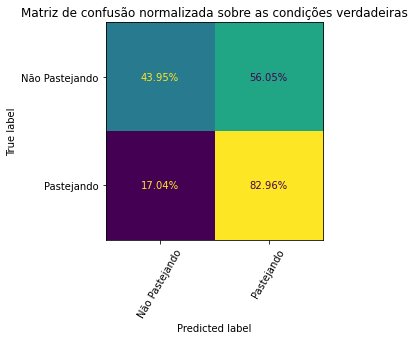

Acurácia treino:  80.56748164429428
                precision    recall  f1-score   support

Não Pastejando      0.824     0.762     0.792    174904
    Pastejando      0.791     0.847     0.818    185883

      accuracy                          0.806    360787
     macro avg      0.807     0.804     0.805    360787
  weighted avg      0.807     0.806     0.805    360787

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       min_samples_split=30, n_estimators=200, n_jobs=-1,
                       random_state=0)
Acurácia teste:  67.71836680020945
                precision    recall  f1-score   support

Não Pastejando      0.633     0.482     0.547     99734
    Pastejando      0.697     0.810     0.749    146629

      accuracy                          0.677    246363
     macro avg      0.665     0.646     0.648    246363
  weighted avg      0.671     0.677     0.667    246363



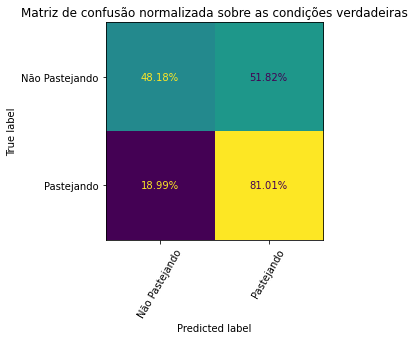

Acurácia treino:  87.27836645998886
                precision    recall  f1-score   support

Não Pastejando      0.892     0.839     0.865    174904
    Pastejando      0.857     0.904     0.880    185883

      accuracy                          0.873    360787
     macro avg      0.874     0.872     0.872    360787
  weighted avg      0.874     0.873     0.873    360787

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=46,
                     weights='distance')
Acurácia teste:  67.18622520427175
                precision    recall  f1-score   support

Não Pastejando      0.621     0.487     0.546     99734
    Pastejando      0.696     0.798     0.743    146629

      accuracy                          0.672    246363
     macro avg      0.658     0.642     0.644    246363
  weighted avg      0.665     0.672     0.663    246363



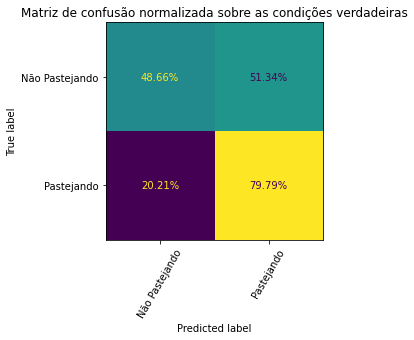

Acurácia treino:  99.99113050082181
                precision    recall  f1-score   support

Não Pastejando      1.000     1.000     1.000    174904
    Pastejando      1.000     1.000     1.000    185883

      accuracy                          1.000    360787
     macro avg      1.000     1.000     1.000    360787
  weighted avg      1.000     1.000     1.000    360787

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              random_state=0)
Acurácia teste:  65.2374747831452
                precision    recall  f1-score   support

Não Pastejando      0.605     0.409     0.488     99734
    Pastejando      0.670     0.818     0.737    146629

      accuracy                          0.652    246363
     macro avg      0.637     0.613     0.612    246363
  weighted avg      0.644     0.652     0.636    246363



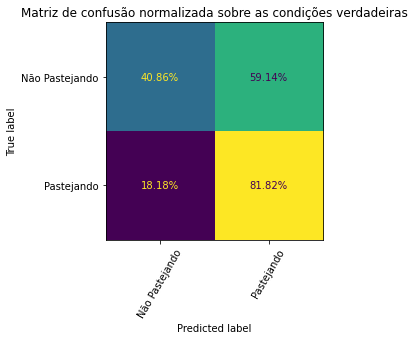

Acurácia treino:  77.08980645089763
                precision    recall  f1-score   support

Não Pastejando      0.786     0.724     0.754    174904
    Pastejando      0.758     0.815     0.786    185883

      accuracy                          0.771    360787
     macro avg      0.772     0.770     0.770    360787
  weighted avg      0.772     0.771     0.770    360787

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.631278076735511,
              enable_categorical=False, gamma=0.0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.008851671496973969, max_delta_step=None,
              max_depth=16, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=0,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
           

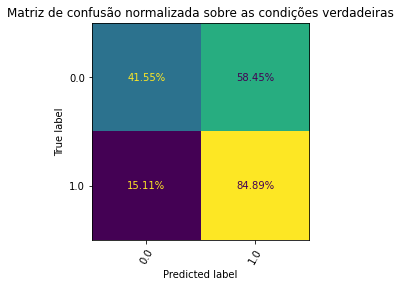

Acurácia treino:  86.33542782860802
              precision    recall  f1-score   support

         0.0      0.885     0.825     0.854    174904
         1.0      0.845     0.899     0.871    185883

    accuracy                          0.863    360787
   macro avg      0.865     0.862     0.863    360787
weighted avg      0.865     0.863     0.863    360787



In [62]:
treinar_e_roportar(models, X_train, y_train, X_test, y_test)   

##### Com GLM 

In [29]:
df_test = df[df.Season_fall == 1]

In [30]:
df_train = df[df.Season_fall == 0]

         Current function value: 0.653760
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  62.25853719917358
              precision    recall  f1-score   support

           0      0.578     0.250     0.349     99734
           1      0.632     0.876     0.734    146629

   micro avg      0.623     0.623     0.623    246363
   macro avg      0.605     0.563     0.542    246363
weighted avg      0.610     0.623     0.578    246363
 samples avg      0.623     0.623     0.623    246363



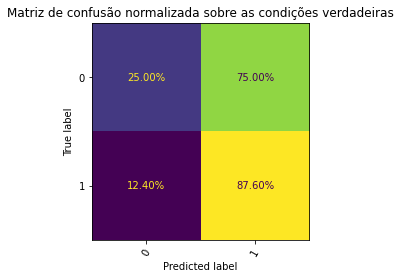

In [31]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Height Out 10 cm

In [63]:
df_test = df[df['Altura esperada'] == 10.0]

In [64]:
df_train = df[df['Altura esperada'] != 10.0]

In [65]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier(colsample_bytree=0.671, min_child_samples=88, num_leaves=512,
               random_state=0, subsample=0.729, subsample_freq=1)
Acurácia teste:  60.07532448248166
                precision    recall  f1-score   support

Não Pastejando      0.582     0.323     0.416     65083
    Pastejando      0.607     0.818     0.697     83076

      accuracy                          0.601    148159
     macro avg      0.594     0.571     0.556    148159
  weighted avg      0.596     0.601     0.573    148159



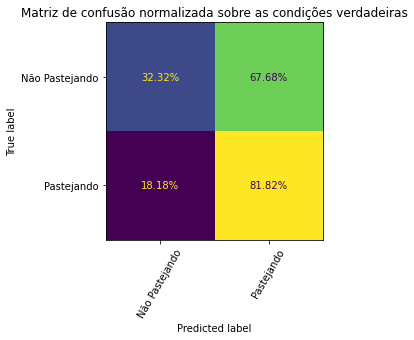

Acurácia treino:  83.53845718107763
                precision    recall  f1-score   support

Não Pastejando      0.840     0.789     0.814    209555
    Pastejando      0.832     0.874     0.852    249436

      accuracy                          0.835    458991
     macro avg      0.836     0.832     0.833    458991
  weighted avg      0.836     0.835     0.835    458991

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       min_samples_split=30, n_estimators=200, n_jobs=-1,
                       random_state=0)
Acurácia teste:  60.00445467369515
                precision    recall  f1-score   support

Não Pastejando      0.583     0.313     0.408     65083
    Pastejando      0.605     0.825     0.698     83076

      accuracy                          0.600    148159
     macro avg      0.594     0.569     0.553    148159
  weighted avg      0.596     0.600     0.570    148159



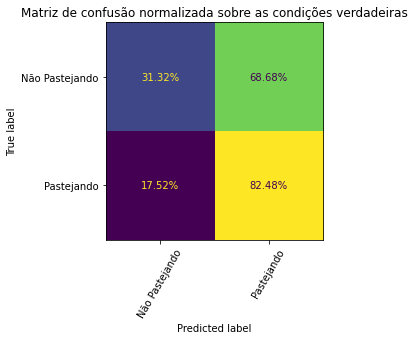

Acurácia treino:  88.44291064530677
                precision    recall  f1-score   support

Não Pastejando      0.897     0.844     0.870    209555
    Pastejando      0.875     0.919     0.896    249436

      accuracy                          0.884    458991
     macro avg      0.886     0.881     0.883    458991
  weighted avg      0.885     0.884     0.884    458991

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=46,
                     weights='distance')
Acurácia teste:  59.53266423234498
                precision    recall  f1-score   support

Não Pastejando      0.567     0.335     0.421     65083
    Pastejando      0.605     0.799     0.689     83076

      accuracy                          0.595    148159
     macro avg      0.586     0.567     0.555    148159
  weighted avg      0.588     0.595     0.571    148159



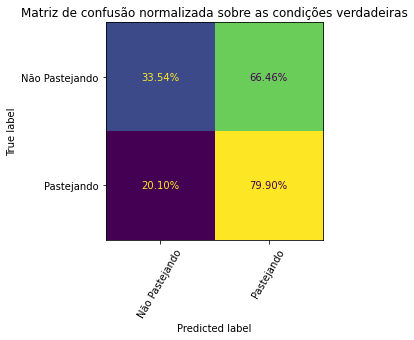

Acurácia treino:  99.99259244734647
                precision    recall  f1-score   support

Não Pastejando      1.000     1.000     1.000    209555
    Pastejando      1.000     1.000     1.000    249436

      accuracy                          1.000    458991
     macro avg      1.000     1.000     1.000    458991
  weighted avg      1.000     1.000     1.000    458991

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              random_state=0)
Acurácia teste:  59.749998312623596
                precision    recall  f1-score   support

Não Pastejando      0.576     0.317     0.409     65083
    Pastejando      0.604     0.817     0.695     83076

      accuracy                          0.597    148159
     macro avg      0.590     0.567     0.552    148159
  weighted avg      0.592     0.597     0.569    148159



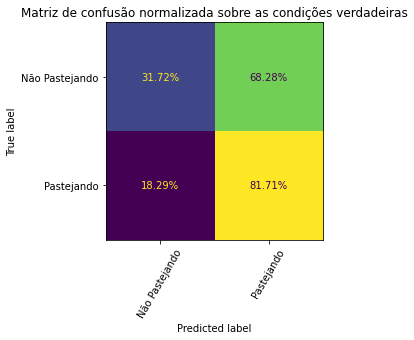

Acurácia treino:  81.03971537568275
                precision    recall  f1-score   support

Não Pastejando      0.807     0.768     0.787    209555
    Pastejando      0.813     0.846     0.829    249436

      accuracy                          0.810    458991
     macro avg      0.810     0.807     0.808    458991
  weighted avg      0.810     0.810     0.810    458991

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.631278076735511,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.008851671496973969, max_delta_step=0,
              max_depth=16, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree

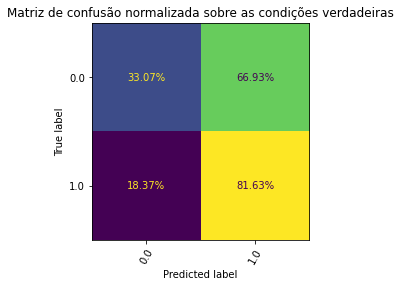

Acurácia treino:  87.71914917721698
              precision    recall  f1-score   support

         0.0      0.885     0.840     0.862    209555
         1.0      0.871     0.909     0.889    249436

    accuracy                          0.877    458991
   macro avg      0.878     0.874     0.876    458991
weighted avg      0.878     0.877     0.877    458991



In [66]:
treinar_e_roportar(models, X_train, y_train, X_test, y_test) 

##### Com GLM 

In [32]:
df_test = df[df['Altura esperada'] == 10.0]

In [33]:
df_train = df[df['Altura esperada'] != 10.0]

         Current function value: 0.633380
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  54.56435316113095
              precision    recall  f1-score   support

           0      0.472     0.293     0.362     65083
           1      0.573     0.744     0.647     83076

   micro avg      0.546     0.546     0.546    148159
   macro avg      0.523     0.518     0.504    148159
weighted avg      0.529     0.546     0.522    148159
 samples avg      0.546     0.546     0.546    148159



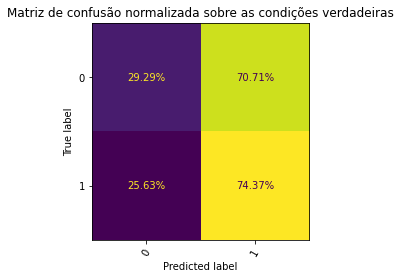

In [34]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')

#### Leave Animals Out

In [67]:
df.Animal.value_counts()

95     119449
81     113724
84     110268
93      98043
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [68]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [69]:
df_test.Animal.value_counts()

84    110268
93     98043
Name: Animal, dtype: int64

In [70]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

In [71]:
df_train.Animal.value_counts()

95     119449
81     113724
21      58809
22      58734
90      47549
105       574
Name: Animal, dtype: int64

In [72]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento
X_train, X_test = reescalar_dados(X_train, X_test)

LGBMClassifier(colsample_bytree=0.671, min_child_samples=88, num_leaves=512,
               random_state=0, subsample=0.729, subsample_freq=1)
Acurácia teste:  59.96034774927872
                precision    recall  f1-score   support

Não Pastejando      0.592     0.367     0.453     94114
    Pastejando      0.603     0.791     0.684    114197

      accuracy                          0.600    208311
     macro avg      0.597     0.579     0.569    208311
  weighted avg      0.598     0.600     0.580    208311



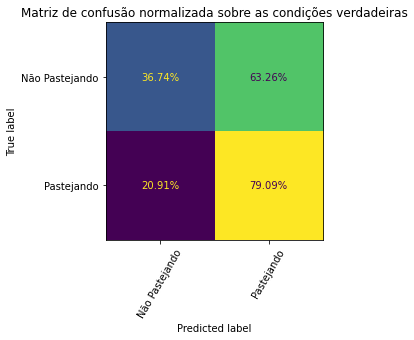

Acurácia treino:  83.30103124318335
                precision    recall  f1-score   support

Não Pastejando      0.845     0.773     0.807    180524
    Pastejando      0.825     0.882     0.853    218315

      accuracy                          0.833    398839
     macro avg      0.835     0.828     0.830    398839
  weighted avg      0.834     0.833     0.832    398839

RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       min_samples_split=30, n_estimators=200, n_jobs=-1,
                       random_state=0)
Acurácia teste:  59.40924867145758
                precision    recall  f1-score   support

Não Pastejando      0.585     0.351     0.439     94114
    Pastejando      0.598     0.794     0.682    114197

      accuracy                          0.594    208311
     macro avg      0.591     0.573     0.560    208311
  weighted avg      0.592     0.594     0.572    208311



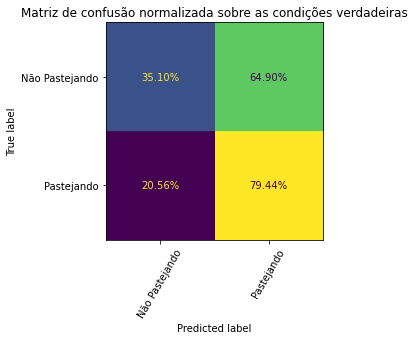

Acurácia treino:  88.54600477887067
                precision    recall  f1-score   support

Não Pastejando      0.902     0.838     0.869    180524
    Pastejando      0.874     0.924     0.898    218315

      accuracy                          0.885    398839
     macro avg      0.888     0.881     0.884    398839
  weighted avg      0.886     0.885     0.885    398839

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=46,
                     weights='distance')
Acurácia teste:  60.447599982718145
                precision    recall  f1-score   support

Não Pastejando      0.589     0.411     0.484     94114
    Pastejando      0.611     0.764     0.679    114197

      accuracy                          0.604    208311
     macro avg      0.600     0.587     0.582    208311
  weighted avg      0.601     0.604     0.591    208311



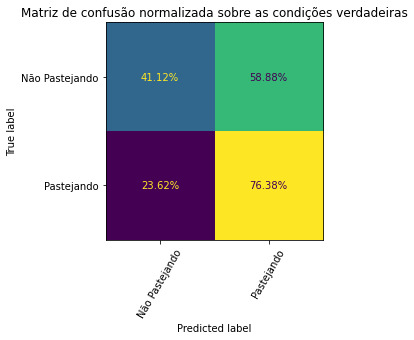

Acurácia treino:  99.99423326204308
                precision    recall  f1-score   support

Não Pastejando      1.000     1.000     1.000    180524
    Pastejando      1.000     1.000     1.000    218315

      accuracy                          1.000    398839
     macro avg      1.000     1.000     1.000    398839
  weighted avg      1.000     1.000     1.000    398839

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30, 30, 20),
              random_state=0)
Acurácia teste:  60.7601134841655
                precision    recall  f1-score   support

Não Pastejando      0.600     0.395     0.476     94114
    Pastejando      0.611     0.783     0.686    114197

      accuracy                          0.608    208311
     macro avg      0.605     0.589     0.581    208311
  weighted avg      0.606     0.608     0.591    208311



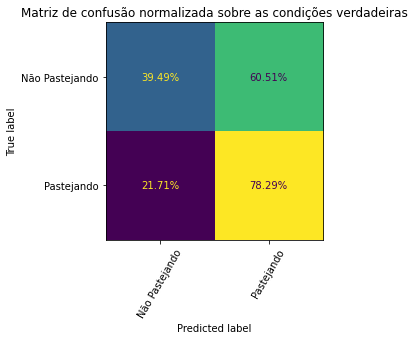

Acurácia treino:  80.23011791725483
                precision    recall  f1-score   support

Não Pastejando      0.803     0.746     0.773    180524
    Pastejando      0.801     0.849     0.825    218315

      accuracy                          0.802    398839
     macro avg      0.802     0.797     0.799    398839
  weighted avg      0.802     0.802     0.801    398839

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.631278076735511,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.008851671496973969, max_delta_step=0,
              max_depth=16, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree

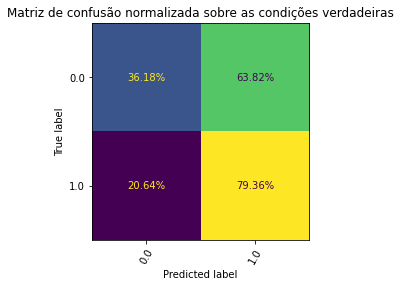

Acurácia treino:  88.23359801824796
              precision    recall  f1-score   support

         0.0      0.898     0.835     0.865    180524
         1.0      0.871     0.922     0.896    218315

    accuracy                          0.882    398839
   macro avg      0.885     0.878     0.880    398839
weighted avg      0.883     0.882     0.882    398839



In [73]:
treinar_e_roportar(models, X_train, y_train, X_test, y_test)

##### Com GLM 

In [35]:
df_test = df.loc[df['Animal'].isin([84, 93])]

In [36]:
df_train = df.loc[~df['Animal'].isin([84, 93])]

         Current function value: 0.641980
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/caio/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Acurácia teste:  60.28534258872551
              precision    recall  f1-score   support

           0      0.607     0.344     0.439     94114
           1      0.602     0.816     0.693    114197

   micro avg      0.603     0.603     0.603    208311
   macro avg      0.604     0.580     0.566    208311
weighted avg      0.604     0.603     0.578    208311
 samples avg      0.603     0.603     0.603    208311



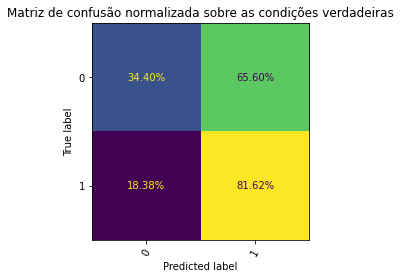

In [37]:
glm_treinar_e_reportar(df_train, df_test, method = 'bfgs')